<a href="https://colab.research.google.com/github/dlbkv/AI-Step/blob/master/lab_detection_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torchvision.io.image import read_image
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from torchvision import transforms

# Завантажуємо зображення
img = read_image("/content/cat.jpg")

# Змінюємо розмір
img = transforms.Resize((720,720))(img)

# Завантажуємо натреновану модель
weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = deeplabv3_resnet50(weights=weights)
model.eval()

# Завантажуємо препроцесор для моделі(без зміни розмірів)
preprocess = weights.transforms(resize_size=None)

# Обробляєио забраження та змінюємо розмірність до [1, 3, width, height]
batch = preprocess(img)
batch = batch.unsqueeze(0)

# Робимо прогноз
with torch.no_grad():
  prediction = model(batch)["out"]

masks = prediction.argmax(dim=1)
mask = masks[0]

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:02<00:00, 83.4MB/s]


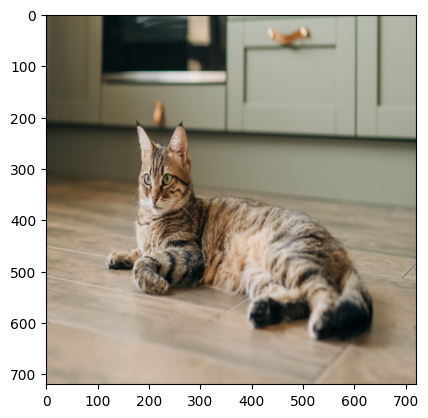

In [4]:
import matplotlib.pyplot as plt

# Візуалізація
plt.imshow(img.permute(1, 2, 0))

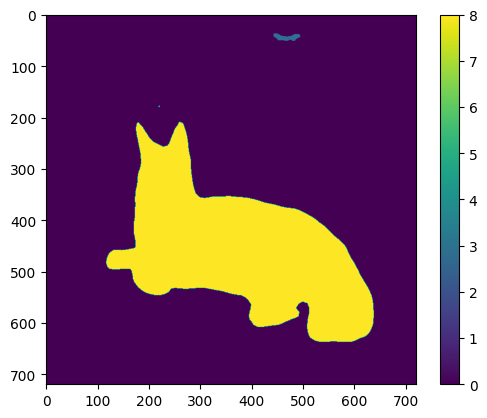

In [5]:
plt.imshow(mask)
plt.colorbar()

In [6]:
mask.unique()

tensor([0, 3, 8])

In [7]:
class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}
class_to_idx

{'__background__': 0,
 'aeroplane': 1,
 'bicycle': 2,
 'bird': 3,
 'boat': 4,
 'bottle': 5,
 'bus': 6,
 'car': 7,
 'cat': 8,
 'chair': 9,
 'cow': 10,
 'diningtable': 11,
 'dog': 12,
 'horse': 13,
 'motorbike': 14,
 'person': 15,
 'pottedplant': 16,
 'sheep': 17,
 'sofa': 18,
 'train': 19,
 'tvmonitor': 20}

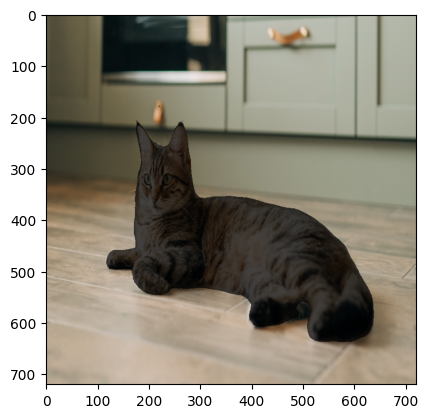

In [8]:
from torchvision.utils import draw_segmentation_masks

cat_mask = mask == class_to_idx['cat']

masked_img = draw_segmentation_masks(img, cat_mask, alpha=0.7)

plt.imshow(masked_img.permute(1, 2, 0))

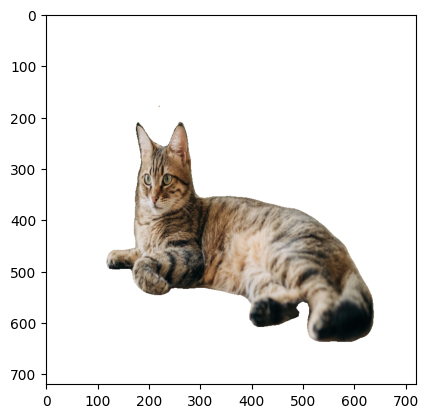

In [9]:
masked_img = img.clone() # копіювання
masked_img = masked_img.to(int) # зміна типу даних на int

color_pixel = torch.tensor([255, 255, 255])
masked_img[:, ~cat_mask] = color_pixel.view(-1, 1)

plt.imshow(masked_img.permute(1, 2, 0))

In [14]:
!pip install -q ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 8.1 MB/s eta 0:00:00


In [25]:
classes_to_detect = [idx for idx, cls in model.names.items() if cls in ['vase', 'potted plant', 'wine glass']]

In [26]:
classes_to_detect

[40, 58, 75]

In [58]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n.pt')  # pretrained YOLOv8n model

# Run batched inference on a list of images
results = model.predict(source='https://www.thespruce.com/thmb/o_zAsNy0xWNWeq9xfWwAo6fhueo=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/SPR-luxury-kitchens-5211364-hero-688d716970544978bc12abdf17ce6f83.jpg',
                        imgsz=840,
                        conf = 0.25,
                        iou=0.6,
                        classes=classes_to_detect)

result = results[0]


WARNING ⚠️ imgsz=[840] must be multiple of max stride 32, updating to [864]
Found https://www.thespruce.com/thmb/o_zAsNy0xWNWeq9xfWwAo6fhueo=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/SPR-luxury-kitchens-5211364-hero-688d716970544978bc12abdf17ce6f83.jpg locally at SPR-luxury-kitchens-5211364-hero-688d716970544978bc12abdf17ce6f83.jpg
image 1/1 /content/SPR-luxury-kitchens-5211364-hero-688d716970544978bc12abdf17ce6f83.jpg: 576x864 4 wine glasss, 3 potted plants, 2 vases, 312.1ms
Speed: 7.4ms preprocess, 312.1ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 864)


In [59]:
import matplotlib.pyplot as plt

image_with_detection = result.plot(filename='result.png',
                                 save=True)

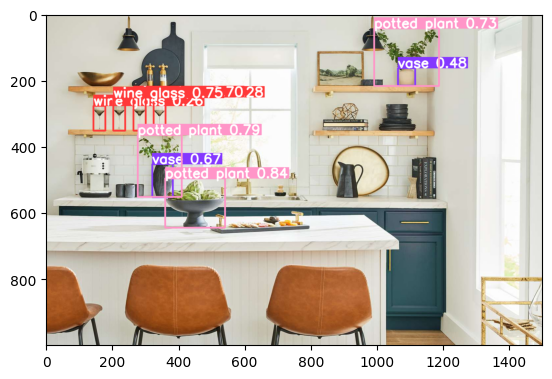

In [60]:
plt.imshow(image_with_detection[:, :, ::-1])

In [66]:
len(result.boxes)

9